In [1]:
from amalearn.reward import RewardBase
from amalearn.agent import AgentBase

In [2]:
from amalearn.environment import EnvironmentBase
import gym
import numpy as np
import matplotlib.pyplot as plt

In [3]:

class Environment(EnvironmentBase):
    def __init__(self, obstacle = [] ,id = 0, action_count=9, actionPrice = -1, goalReward = 100, punish=-10, j_limit = 10, i_limit = 10, p = 0.8, container=None):
        """
        initialize your variables
        """
        state_space = gym.spaces.MultiDiscrete([17,17])
        action_space = gym.spaces.Discrete(9)
        super(Environment, self).__init__(action_space,state_space,id,container)
        
        
        self.opt_policy = None
        self.opt_values = None
        self.state = [15,15]
        self.mu = p
        self.goalReward = goalReward
        self.punish = punish
        self.actionPrice = actionPrice
        self.state_space = state_space
        
    def isStatePossible(self, state):
        """if given state is possible (not out of the grid and not obstacle) return ture"""
        x, y = state[0], state[1]
        if x < 1 or x > 15 or y < 1 or y > 15:
            return False
        
        if x == 6 or x == 7:
            if y > 11:
                return False
        
        if x == 7 or x == 8:
            if y < 5: 
                return False
            
        if x > 12:
            if y == 8 or y == 9:
                return False
            
        return True
    
    def isAccessible(self, state, state_p):
        """if given state is Accesible (we can reach state_p by doing an action from state) return true"""
        if np.abs(state[0] - state_p[0]) > 1 or np.abs(state[1] - state_p[1]) > 1:
            return False
        else:
            return self.isStatePossible(state_p)
        
    def getTransitionStatesAndProbs(self, state, action, state_p):
        """return probability of transition or T(sp,a,s)"""
        act = self.get_action(action)
        p = 0
        f = 0
        if state[0] + act[0] == state_p[0] and state[1] + act[1] == state_p[1]:
            p = p + self.mu
        
        for i in [-1,0,1]:
            for j in [-1,0,1]:
                f += self.isAccessible(state, [state[0]+i, state[1]+j])
        
        if self.isAccessible(state, state_p):
            p = p + 0.2/f
        
        return p
    
    def getReward(self, state, action, state_p):
        """return reward of transition"""
        if state_p[0] == 1 and state_p[1] == 1:
            return self.goalReward
        
        if self.isAccessible(state, state_p):
            return self.actionPrice
        
        return self.punish
    
    def sample_all_rewards(self):
        return 
    
    def get_action(self, action):
        if action == 0:
            return [-1,-1]
        if action == 1:
            return [-1,0]
        if action == 2:
            return [-1,1]
        if action == 3:
            return [0,-1]
        if action == 4:
            return [0,0]
        if action == 5:
            return [0,1]
        if action == 6:
            return [1,-1]
        if action == 7:
            return [1,0]
        if action == 8:
            return [1,1]


    def calculate_reward(self, action):
        s = self.state
        sp = self.pred(action)
        return self.getReward(s,action,sp)

    def terminated(self):
        return self.state == [1,1] 

    def observe(self):
        return self.state

    def available_actions(self):
        return [0,1,2,3,4,5,6,7,8]

    def pred(self, action):
        s = self.state
        prob = np.zeros((9,))
        act = self.get_action(action)
        s_p = []
        for i in [-1,0,1]:
            for j in [-1,0,1]:
                s_p.append([s[0] + i, s[1] + j])
        for i in range(9):
            prob[i] = self.getTransitionStatesAndProbs(s, action, s_p[i])
            
        c = np.random.choice(self.available_actions(), p = prob)
        c = self.get_action(c)
        next_state = [0,0]
        next_state[0] = s[0] + c[0]
        next_state[1] = s[1] + c[1]
        self.sp = next_state
        return next_state
    
    def next_state(self,action):
        s = self.state
        if self.isAccessible(s,self.sp):
            self.state = self.sp
            return self.sp
        return s
    
    def reset(self):
        self.state = [15,15]

    def render(self, mode='human'):
        #print('{}:\taction={}'.format(self.state['length'], self.state['last_action']))
        return 

    def close(self):
        return

In [4]:
import numpy as np

class Agent(AgentBase):
    def __init__(self, id, environment, discount, theta, policy_iteration = True):
        #initialize a random policy and V(s) = 0 for each state
        self.environment = environment
        self.mapp = {}
        #mapp states to its ids
        self.V = np.zeros((17,17))
        #init V
        self.policy = np.random.randint(0,9,(17,17))
        #init policy
        super(Agent, self).__init__(id, environment)
        self.discount = discount
        self.theta = theta
        self.policy_iteration = policy_iteration
    def policy_evaluation(self):
        V = self.V
        while True:
            delta = 0.01
            for i in range(1,16):
                for j in range(1,16):
                    v = self.V[i,j]
                    v_new = 0
                    action = self.policy[i,j]
#                     prob = np.zeros((9,))
#                     rew = np.zeros((9,))
                    for k in [-1,0,1]:
                        for l in [-1,0,1]:
                            rew = ( self.environment.getReward([i,j], action, [i + k, j + l]))
                            prob = (self.environment.getTransitionStatesAndProbs([i,j], action, [i + k, j + l]))
                            v_new += prob*(rew + self.discount*self.V[i+k,j+l])
                    
                    V[i,j] = v_new
                    delta = np.max([delta, np.abs(v_new - v)])
                    if delta < self.theta:
                        return V
                    
    def policy_improvement(self):
        stable = True
        for i in range(1,16):
            for j in range(1,16):
                old_action = self.policy[i,j]
                qs = []
                for action in range(9):
#                     prob = np.zeros((9,))
#                     rew = np.zeros((9,))
                    q = 0
                    for k in [-1,0,1]:
                        for l in [-1,0,1]:
                            rew = ( self.environment.getReward([i,j], action, [i + k, j + l]))
                            prob = (self.environment.getTransitionStatesAndProbs([i,j], action, [i + k, j + l]))
                            q += prob*(rew + self.discount*self.V[i+k,j+l])

                    qs.append(q)

                best_action = np.argmax(qs)
                self.policy[i,j] = best_action
                if best_action != old_action:
                    stable = False
        return stable
    
    def policy_iter(self):
        values = self.V
        policy = self.policy
        stable = False
        while not stable:
            self.V = self.policy_evaluation()
            stable = self.policy_improvement()
            
    def value_iteration(self):
        V = self.V
        pol = np.zeros((17,17), dtype = np.int)
        delta = np.float(0)
        while True:
            V2 = V
            for i in range(1,16):
                for j in range(1,16):
                    v = self.V[i,j]
                    Vs = []
                    for action in range(9):
                        value = 0
                        for k in [-1,0,1]:
                            for l in [-1,0,1]:
                                rew = ( self.environment.getReward([i,j], action, [i + k, j + l]))
                                prob = (self.environment.getTransitionStatesAndProbs([i,j], action, [i + k, j + l]))
                                value += prob*(rew + self.discount*self.V[i+k,j+l])

                        Vs.append(value)
                        V2[i,j] = np.max(Vs)
                        best_action = int(np.argmax(Vs))
                        pol[i,j] = best_action
                        delta = np.max([delta, abs(V[i,j] - V2[i,j])])
            if delta < self.theta:
                self.policy = pol
                break
            V = V2
    
    def visualize_policy(self):
        fig, ax = plt.subplots()

        ax.matshow(self.policy[1:16,1:16].T, cmap='summer')

        for i in range(15):
            for j in range(15):
                c = self.policy.T[j+1,i+1]
                ax.text(i, j, str(c), va='center', ha='center')
        plt.axis('off')
        plt.show() 
        
    def take_action(self):
#         self.environment.reset()
        steps = 0
        if self.policy_iteration:
            self.policy_iter()
        else:
            self.value_iteration()
        states = []
        actions = []
        rews = []
        while True:
            states.append(self.environment.state)
            state = states[-1]
            action = self.policy[state[0], state[1]]
            actions.append(action)
            a,rew,b,c = self.environment.step(action)
            rews.append(rew)
            if self.environment.terminated():
                states.append(self.environment.state)
                break
        return states, actions, rews

(-0.5, 2.5, 2.5, -0.5)

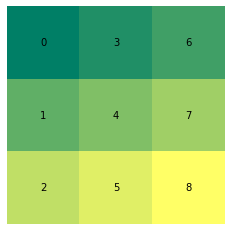

In [5]:
ac = np.array([0,1,2,3,4,5,6,7,8]).reshape((3,3))
fig, ax = plt.subplots()

ax.matshow(ac, cmap='summer')

for i in range(3):
    for j in range(3):
        c = ac[i,j]
        ax.text(i, j, str(c), va='center', ha='center')

plt.axis('off')

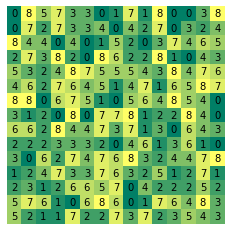

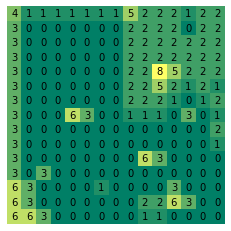

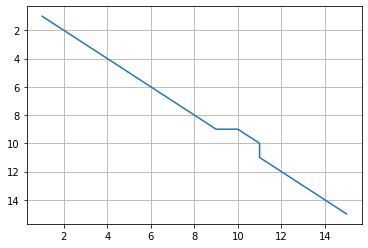

In [6]:
### Base case

env = Environment(punish = -1, actionPrice = -0.01, goalReward= 1000)
agent1 = Agent(0, env, 0.9, 0.1)
agent1.visualize_policy()
states, actions, rews = agent1.take_action()
agent1.visualize_policy()
plt.plot(np.array(states)[:,0], np.array(states)[:,1])
plt.grid()
plt.gca().invert_yaxis()

In [7]:
np.array(states)[0,:]

array([15, 15])

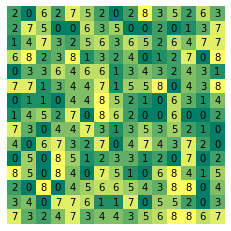

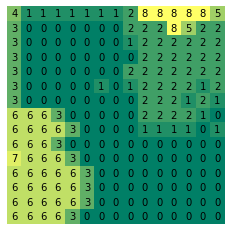

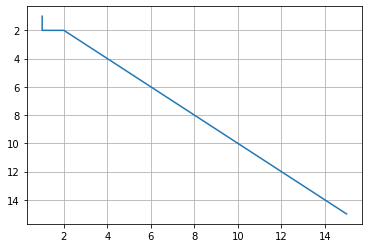

In [8]:
### no punishment

env = Environment(punish = -0.01, actionPrice=0, goalReward=1000)
agent2 = Agent(0, env, 0.9, 0.1)
agent2.visualize_policy()
states, actions, rews = agent2.take_action()
agent2.visualize_policy()
plt.plot(np.array(states)[:,0], np.array(states)[:,1])
# plt.axis('off')
plt.grid()
plt.gca().invert_yaxis()

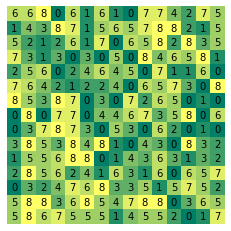

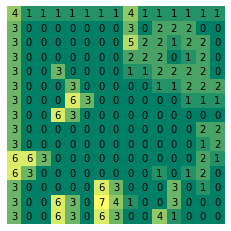

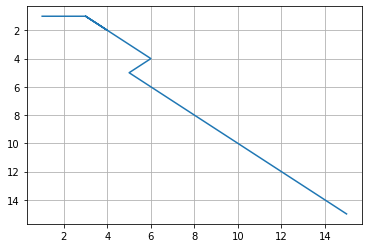

In [9]:
### high punishment
env = Environment(punish = -10, actionPrice=-1, goalReward=100)
agent = Agent(0, env, 0.9, 0.1)
agent.visualize_policy()
states,actions,rewards = agent.take_action()
agent.visualize_policy()
plt.plot(np.array(states)[:,0], np.array(states)[:,1])
# plt.axis('off')
plt.grid()
plt.gca().invert_yaxis()

In [10]:
n_steps_punish = []
for i in range(10):
    env = Environment(punish = -1, actionPrice=-0.01, goalReward=1000)
    agent = Agent(0, env, 0.9, 0.1)
    states,actions,rewards = agent.take_action()
    n_steps_punish.append(len(states))
    print(i, len(states))
    



0 19
1 20
2 27
3 20
4 353
5 171268
6 22
7 18
8 20
9 21


In [11]:
n_steps_no_punish = []
for i in range(10):
    env = Environment(punish = -0.01, actionPrice=0, goalReward=1000)
    agent = Agent(0, env, 0.9, 0.1)
    states,actions,rewards = agent.take_action()
    n_steps_no_punish.append(len(states))
    print(i, len(states))
    

0 21
1 20
2 20
3 30766
4 23
5 20
6 19
7 21
8 29
9 26


In [12]:
n_steps_high_punish = []
for i in range(10):
    env = Environment(punish = -10, actionPrice=-1, goalReward=100)
    agent = Agent(0, env, 0.9, 0.1)
    states,actions,rewards = agent.take_action()
    n_steps_high_punish.append(len(states))
    print(i, len(states))
    


0 16
1 22
2 25
3 40
4 22
5 22
6 1366848
7 17
8 21
9 137


In [13]:

print(f"""

average number of steps for base case: {np.mean(n_steps_punish)}

average number of steps for no punishment case: {np.mean(n_steps_no_punish)}

average number of steps for high punishment case: {np.mean(n_steps_high_punish)}

""")



average number of steps for base case: 17178.8

average number of steps for no punishment case: 3096.5

average number of steps for high punishment case: 136717.0




In [14]:
reward1 = []
for i in range(10):
    env = Environment(punish = -1, actionPrice=-0.01, goalReward=1000)
    agent = Agent(0, env, 0, 0.1)
    states,actions,rewards = agent.take_action()
    reward1.append(np.sum(rewards))
    print(i, np.sum(rewards))


0 950.5
1 998.19
2 826.3299999999999
3 998.3100000000001
4 975.3500000000001
5 913.26
6 937.3500000000001
7 559.11
8 899.2099999999999
9 895.29


In [15]:
reward2 = []
for i in range(10):
    env = Environment(punish = -1, actionPrice=-0.01, goalReward=1000)
    agent = Agent(0, env, 0.3, 0.1)
    states,actions,rewards = agent.take_action()
    reward2.append(np.sum(rewards))
    print(i, np.sum(rewards))
    


0 998.43
1 970.63
2 999.8
3 999.85
4 -1342.7600000000007
5 999.27
6 993.0499999999998
7 342.56000000000006
8 -307595.1300000088
9 999.27


In [16]:
    
reward3 = []
for i in range(10):
    env = Environment(punish = -1, actionPrice=-0.01, goalReward=1000)
    agent = Agent(0, env, 0.5, 0.1)
    states,actions,rewards = agent.take_action()
    reward3.append(np.sum(rewards))
    print(i, np.sum(rewards))
    



0 946.58
1 999.82
2 999.74
3 999.58
4 998.98
5 999.83
6 999.78
7 999.83
8 999.69
9 999.18


In [17]:
    
reward4 = []
for i in range(10):
    env = Environment(punish = -1, actionPrice=-0.01, goalReward=1000)
    agent = Agent(0, env, 0.8, 0.1)
    states,actions,rewards = agent.take_action()
    reward4.append(np.sum(rewards))
    print(i, np.sum(rewards))
    

0 999.73
1 996.78
2 999.81
3 999.83
4 999.8
5 999.85
6 999.79
7 999.81
8 999.87
9 956.76


In [18]:

print(f"""
discount factor = 0, mean reward = {np.mean(reward1)}
discount factor = 0.3, mean reward = {np.mean(reward2)}
discount factor = 0.5, mean reward = {np.mean(reward3)}
discount factor = 0.8, mean reward = {np.mean(reward4)}

""")


discount factor = 0, mean reward = 895.29
discount factor = 0.3, mean reward = -30163.503000000877
discount factor = 0.5, mean reward = 994.301
discount factor = 0.8, mean reward = 995.2030000000001




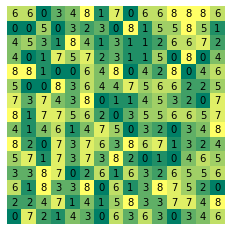

<ipython-input-4-34a3603249cc>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pol = np.zeros((17,17), dtype = np.int)
<ipython-input-4-34a3603249cc>:74: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  delta = np.float(0)


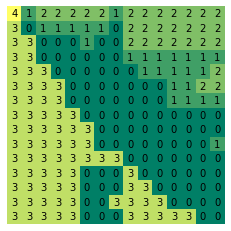

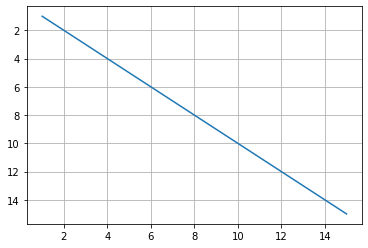

In [19]:
## value iteration
env = Environment(punish = -1, actionPrice=-0.01, goalReward=1000)
agent = Agent(0, env, 0.8, 0.1, False)
agent.visualize_policy()
states,actions,rewards = agent.take_action()
agent.visualize_policy()
plt.plot(np.array(states)[:,0], np.array(states)[:,1])
# plt.axis('off')
plt.grid()
plt.gca().invert_yaxis()

In [20]:
reward5 = []
n_steps5 = []
for i in range(10):
    env = Environment(punish = -1, actionPrice=-0.01, goalReward=1000)
    agent = Agent(0, env, 0.8, 0.1,False)
    states,actions,rewards = agent.take_action()
    reward5.append(np.sum(rewards))
    print(i, np.sum(rewards))
    n_steps5.append(len(states))
    


<ipython-input-4-34a3603249cc>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pol = np.zeros((17,17), dtype = np.int)
<ipython-input-4-34a3603249cc>:74: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  delta = np.float(0)


0 999.78
1 999.85
2 999.84
3 999.87
4 999.84
5 999.87
6 999.86
7 999.83
8 950.67
9 999.87


In [21]:
print(f'''
value iteration agent average reward = {np.mean(reward5)}
value iteration agent average number of steps = {np.mean(n_steps5)}
''')


value iteration agent average reward = 994.9280000000001
value iteration agent average number of steps = 24.1

